# <center> TP4 / Schéma aux différences finies pour les options américaines </center>
<div>
    <center> RAZAFINDRAZAKA Henintsoa </center>
    <center> Wang James </center>
    <center> ____________</center>
    <center> ING5 BDA GR02 </center>
    <center> 22/12/2020 </center>
</div>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
import numpy as np
import math
import time

## 1. Initialisations

### 1.1. Initialisation des paramètres numériques

In [2]:
M = 100      # Nombre de points de maillage d'actifs
N = 400      # Nombre de points de maillage en temps
Szero = 0    # valeur extreme
Smax = 150   # valeur extreme
omega = 1.2  # Paramètre SOR
tol = 0.001  # Paramètre SOR

### 1.2. Initialisation des paramètres financiers

In [3]:
S = 50          # valeur du sous-jacent
K = 50          # Strike
r = 0.05        # Taux d'intérêt sans risque
sigma = 0.25    # Volatilité
T = 3           # Maturité

### 1.3. Initialisation du maillage et de la matrice du système linéaire

In [4]:
u = np.zeros((N, M))

dS = Smax / M
dt = T/N
Smesh = np.arange(0, Smax, dS)
Tmesh = np.arange(T, 0, -dt)

u[0,:] = np.maximum(K-Smesh, 0)
u[:,0] = K*np.exp(-r*(T-Tmesh))
u[:,M-1] = 0

def A(i):
    return 0.5 * dt * (r * i - sigma**2 * i**2)

def B(i):
    return 1 + (sigma**2 * i**2 + r)*dt

def C(i):
    return -0.5 * dt * (sigma**2 * i**2 + r * i)

### 1.4. Construction de la matrice tri-diagonale et son inverse 

In [5]:
Acoeffs = np.zeros((M,))
Bcoeffs = np.zeros((M,))
Ccoeffs = np.zeros((M,))

for i in range(M):
    Acoeffs[i] = A(i)
    Bcoeffs[i] = B(i)
    Ccoeffs[i] = C(i)
    
Tri = np.diag(Acoeffs[2:M], -1) + np.diag(Bcoeffs[1:M]) + np.diag(Ccoeffs[1:M-1], 1) 
Tri_inv = np.linalg.inv(Tri)


## 2. Boucle en temps et schéma implicite pour un Put américain

In [6]:
for j in range(N-1):
    temp = np.zeros((M-2,))
    temp[0] = Acoeffs[0] * u[j+1][0]
    temp[M-3] = C(M) * u[j+1][M-1]
    RHS = u[j,1:M-1] - temp
    
    A = Tri
    b = RHS
    x = u[j,1:M-1]
    xold = 10000 * x
    n = len(x)
    
    while np.linalg.norm(xold - x) > tol:
        xold = x
        for i in range(n):
            if i == 0:
                z = (B(i) - A[i,i+1] * x[i+1]) / A[i,i]
                x[i] = np.maximum(omega * z + (1 - omega) * xold[i], K - i * dS)
            elif i == n-1:
                z = (B(i) - A[i,i-1] * x[i-1]) / A[i,i]
                x[i] = np.maximum(omega * z + (1 - omega) * xold[i], K - i * dS)
            else:
                z = (B(i) - A[i,i-1] * x[i-1] - A[i,i+1] * x[i+1]) / A[i,i]
                x[i] = np.maximum(omega * z + (1 - omega) * xold[i], K - i * dS)
    u[j+1,1:M-1] = x
print("u = \n",u)

u = 
 [[50.         50.         48.5        ...  2.28302097  2.29168011
   0.        ]
 [49.98125352 50.         48.5        ...  3.57383936  2.46185048
   0.        ]
 [49.96251406 50.         48.5        ...  3.74788663  2.51256096
   0.        ]
 ...
 [43.08384089 50.         48.5        ...  3.83030035  2.53754894
   0.        ]
 [43.06768748 50.         48.5        ...  3.83030035  2.53754894
   0.        ]
 [43.05154012 50.         48.5        ...  3.83030035  2.53754894
   0.        ]]


## 3. Visualisation graphique des résultats

### 3.1. Figure 1: Iso-valeurs de Put Américain

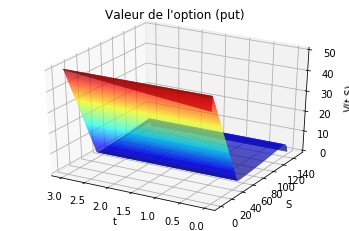

In [7]:
X, Y = np.meshgrid(Tmesh, Smesh)

ax = plt.axes(projection='3d')
plt.gca().invert_xaxis()
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel('V(t,S)')
ax.plot_surface(X, Y, u.T, rstride=1, cstride=1, cmap='jet')
ax.set_title("Valeur de l'option (put)");

### 3.2. Figure 2: Variations 1D du Put Américain

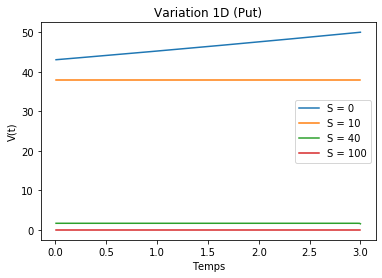

In [8]:
plt.plot(Tmesh, u[:,0], label='S = 0')
plt.plot(Tmesh, u[:,9], label='S = 10')
plt.plot(Tmesh, u[:,39], label='S = 40')
plt.plot(Tmesh, u[:,99], label='S = 100')
plt.xlabel('Temps')
plt.ylabel('V(t)')
plt.legend()
plt.title('Variation 1D (Put)')
plt.show()

## 4. Implémentation d'un Call américain

### 4.1. Initialisation des paramètres numériques et Financiers

In [20]:
M = 100        # Nombre de points de maillage d'actifs
N = 400        # Nombre de points de maillage en temps
Szero = 0      # valeur extreme
Smax = 150     # valeur extreme
omega = 1.2  # Paramètre SOR
tol = 0.001  # Paramètre SOR

S = 50         # valeur du sous-jacent
K = 50         # Strike
r = 0.05       # Taux d'intérêt sans risque
sigma = 0.25    # Volatilité
T = 3          # Maturité

### 4.2. Initialisation du maillage et construction de la matrice du système linéaire

In [21]:
u = np.zeros((N, M))

dS = Smax / M
dt = T/N
Smesh = np.arange(0, Smax, dS)
Tmesh = np.arange(T, 0, -dt)

u[0,:] = np.maximum(Smesh-K, 0)
u[:,0] = 0
u[:,M-1] = Smax

def A(i):
    return 0.5 * dt * (r * i - sigma**2 * i**2)

def B(i):
    return 1 + (sigma**2 * i**2 + r)*dt

def C(i):
    return -0.5 * dt * (sigma**2 * i**2 + r * i)

Acoeffs = np.zeros((M,))
Bcoeffs = np.zeros((M,))
Ccoeffs = np.zeros((M,))

for i in range(M):
    Acoeffs[i] = A(i)
    Bcoeffs[i] = B(i)
    Ccoeffs[i] = C(i)
    
Tri = np.diag(Acoeffs[2:M], -1) + np.diag(Bcoeffs[1:M]) + np.diag(Ccoeffs[1:M-1], 1) 
Tri_inv = np.linalg.inv(Tri)

### 4.3. Boucle en temps et schéma implicite

In [22]:
for j in range(N-1):
    temp = np.zeros((M-2,))
    temp[0] = Acoeffs[0] * u[j+1][0]
    temp[M-3] = C(M) * u[j+1][M-1]
    RHS = u[j,1:M-1] - temp
    
    A = Tri
    b = RHS
    x = u[j,1:M-1]
    xold = 10000 * x
    n = len(x)
    
    while np.linalg.norm(xold - x) > tol:
        xold = x
        for i in range(n):
            if i == 0:
                z = (B(i) - A[i,i+1] * x[i+1]) / A[i,i]
                x[i] = np.maximum(omega * z + (1 - omega) * xold[i], i * dS - K)
            elif i == n-1:
                z = (B(i) - A[i,i-1] * x[i-1]) / A[i,i]
                x[i] = np.maximum(omega * z + (1 - omega) * xold[i], i * dS - K)
            else:
                z = (B(i) - A[i,i-1] * x[i-1] - A[i,i+1] * x[i+1]) / A[i,i]
                x[i] = np.maximum(omega * z + (1 - omega) * xold[i], i * dS - K)
    u[j+1,1:M-1] = x
print("u = \n",u)

u = 
 [[  0.           1.19943797   1.19912409 ...  94.          95.5
  150.        ]
 [  0.           0.96015692   0.96102296 ...  94.          95.5
  150.        ]
 [  0.           1.0078927    1.0083037  ...  94.          95.5
  150.        ]
 ...
 [  0.           0.99995336   1.00047013 ...  94.          95.5
  150.        ]
 [  0.           0.99995336   1.00047013 ...  94.          95.5
  150.        ]
 [  0.           0.99995336   1.00047013 ...  94.          95.5
  150.        ]]


### 4.4. Visualisation graphique des résultats

#### 4.4.1. Figure 1: Iso-valeurs de Call Américain

(400,)
(100,)
(400, 100)


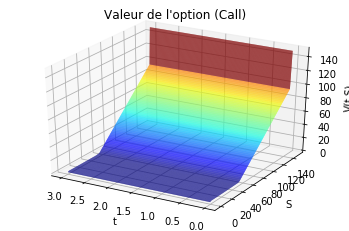

In [23]:
X, Y = np.meshgrid(Tmesh, Smesh)
print(Tmesh.shape)
print(Smesh.shape)
print(u.shape)
ax = plt.axes(projection='3d')
plt.gca().invert_xaxis()
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel('V(t,S)')
ax.plot_surface(X, Y, u.T, rstride=1, cstride=1, cmap='jet')
ax.set_title("Valeur de l'option (Call)");

#### 4.4.2. Figure 2: Variations 1D du Call Américain

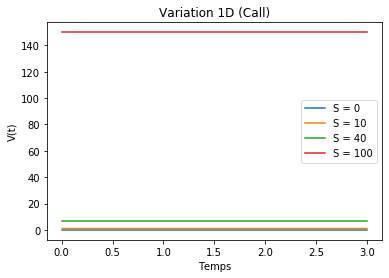

In [24]:
plt.plot(Tmesh, u[:,0], label='S = 0')
plt.plot(Tmesh, u[:,9], label='S = 10')
plt.plot(Tmesh, u[:,39], label='S = 40')
plt.plot(Tmesh, u[:,99], label='S = 100')

plt.xlabel('Temps')
plt.ylabel('V(t)')
plt.legend()
plt.title('Variation 1D (Call)')
plt.show()